# Multiclass dog breed classification

This notebook builds an multiclass image classifier using TensorFlow 2.0 and TensorFlow Hub.

## Problem
Identifying the breed of a dog given its image.

## Data
We are using the data provided by Kaggle's dog breed identification competition. See https://www.kaggle.com/competitions/dog-breed-identification/data.

## Evaluation

A file with prediction probabilities for each dog breed of each test image will be evatualuated on Multi Class Log Loss. See https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation.

## Features
* We are dealing with unstructured data (images).
* There are 120 breeds of dogs (so 120 different classes).
* 10k+ images in the training set (with labels).
* 10k+ images in the test set (no labels).

## Getting our workspace ready

In [15]:
# Import tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

#Check for GPU availability
print("GPU", "available (YES!)" if tf.config.list_physical_devices("GPU") else "not available (no :c)")

TF version: 2.9.2
TF Hub version: 0.12.0
GPU available (YES!)


## Getting our data ready (and a little bit of exploration)

In [16]:
# Chechout the labels of our data
import pandas as pd
import numpy as np


labels_csv = pd.read_csv("drive/MyDrive/Colab Notebooks/dog-breed-identification/labels.csv")
labels = labels_csv["breed"].to_numpy()
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


In [17]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


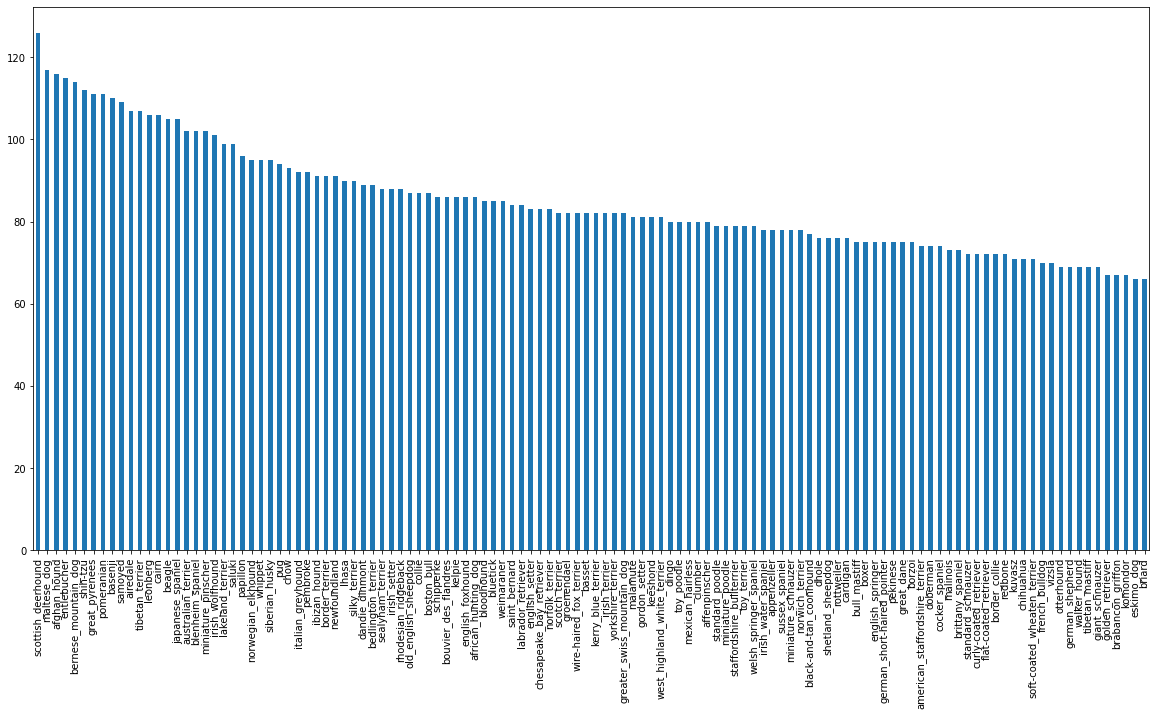

In [18]:
#How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize = (20,10))
# Google recommends at least 10 examples of each class, so we are fine

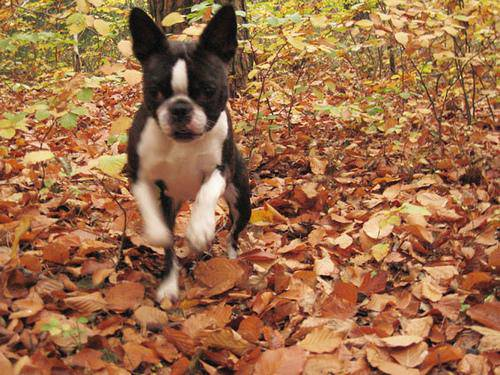

In [19]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Colab Notebooks/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

In [20]:
#Let's get a list of all our images file pathnames
filenames = ["drive/MyDrive/Colab Notebooks/dog-breed-identification/train/" + fname + ".jpg" for fname in labels_csv["id"]]

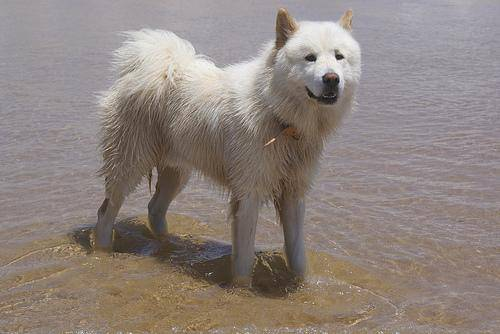

In [21]:
Image(filenames[9034])

In [22]:
labels_csv["breed"][9034]

'samoyed'

In [23]:
# See if the number of labels is equal to the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames")

Number of labels matches number of filenames!


In [24]:
#Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [25]:
#Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
print(boolean_labels[:1])
print(boolean_labels[1].astype(int))

[array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

## Creating validation set

In [26]:
# Setup X and Y variables
X = filenames
Y = boolean_labels
len(X)

10222

In [27]:
#Set the number of images we will use for experiments
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [28]:
 from sklearn.model_selection import train_test_split

# We will split the data into training and validation sets of total NUM_IMAGES
X_train, X_val, Y_train, Y_val = train_test_split(X[:NUM_IMAGES], Y[:NUM_IMAGES], test_size = 0.2, random_state = 42)

## Preprocessing images (turning images into Tensors)
1. Take a image path as input
2. User TensorFlow to read the file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the images to be a shape of (224, 224) 
5. return the `image`

The preprocess will be based in https://www.tensorflow.org/tutorials/load_data/images

In [29]:
from matplotlib.pyplot import imread
image = imread(filenames[42])

In [30]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [31]:
#Turning the image into a tensor
tf.constant(image[:2])

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [32]:
#Define image size (that number comes from the model we will choose in the future. Different models, maybe different sizes)
IMG_SIZE = 224

#Create a function for preprocessing images
def process_image(image_path):
  """
  Takes an image file path and turns the image into a Tensor. 
  """
  #Read
  image = tf.io.read_file(image_path)
  #turn the jpeg image into numerical Tensor (RGB code)
  image = tf.image.decode_jpeg(image, channels = 3)
  #Convert the colors channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  #Resize
  image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE]) 
  return image

## Turning datas into batches
We will "split" the datas into small portions (32 images, to be exact) and process them one after another, the goal is to make the process fit into the memory.

In order to use TensorFlow, we need our data in the form of Tensor tuples like that: `(image, label)`.

In [33]:
#Get the tuples
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label  

BATCH_SIZE = 32
def create_data_batches(X, Y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  """
  Creates batches of data ut of images and label pairs.
  It shuffles the data if it is training data but doesn't shuffle if it is validation data.
  Also accepts test data as input (no label).
  """ 
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  elif  valid_data:
    print("Creating valid data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))
    #shuffle
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [34]:
 # Create training and validation data batches
 train_data = create_data_batches(X_train, Y_train)
 val_data = create_data_batches(X_val, Y_val, valid_data = True)

Creating training data batches...
Creating valid data batches...


## Visualizing data batches

In [35]:
import matplotlib.pyplot as plt
def show_25_images(images, labels):
  plt.figure(figsize = (10,10))
  for i in range(25):
    ax=plt.subplot(5, 5, i+1) #(number rows, columns, index)
    #display an image
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

In [36]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

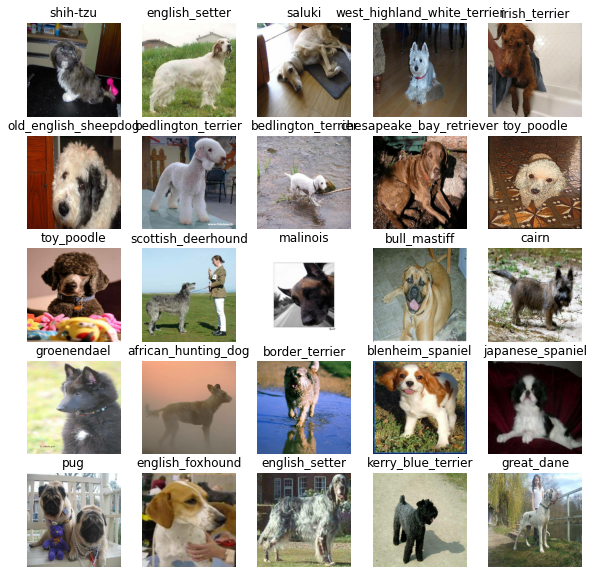

In [ ]:
#Visualizing training sets
train_images, train_labels=next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

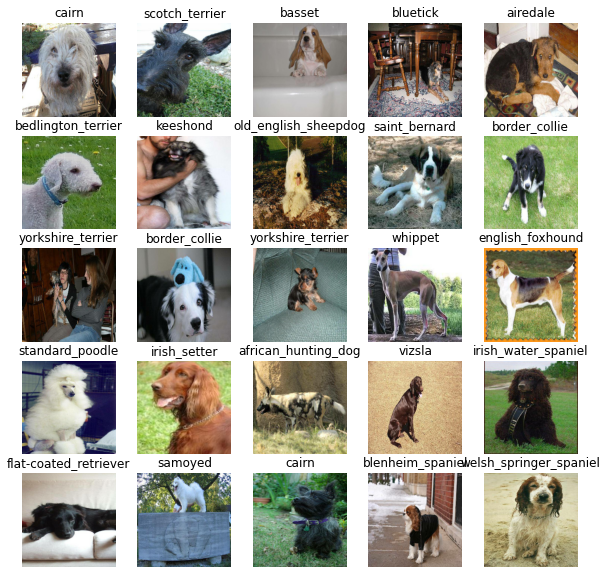

In [ ]:
#Visualizing validation sets
val_images, val_labels=next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

In [37]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #Batch, height, widht, colors chanel (RGB)

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

#Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we got our inputs, outputs and model ready to go. We will put them together into a keras deep learning model. We will create a function that do the following:
* Takes as parameters the input shape, output shape and the model we've chosen.
* Defines the layers in a Keras model in a sequential manner.
* Compiles the model (tells how to evaluate and improve)
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model

Source: https://www.tensorflow.org/guide/keras/sequential_model

In [38]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building model with:", MODEL_URL)

  #Setup the model layers
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL), #Layer 1 (input layer)
                              tf.keras.layers.Dense(units=OUTPUT_SHAPE, #we're saying: hey, I don't know how your code sets your output, but I want it as a array of 120 len
                                                    activation = "softmax") #It takes this 120 length array, convert then in the interval (0,1) and take the maximun. It is a smooth approximation of argmax (multiclass classification: activation = softmax. binary classification: activation = sigmoid)
                                                                            #Layer 2 (output layer)
                               ])
  #Compile the model (it is exactly how the code looks like mathematically)
  model.compile(
     loss = tf.keras.losses.CategoricalCrossentropy(), #loss function (multiclass: CategoricalCrossentropy, binary: BinaryCrossentropy)
     optimizer = tf.keras.optimizers.Adam(), #Algorithm to minimize loss function 
     metrics = ["accuracy"] #measurement of goal
  )
  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [39]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks
* We will create one for TensorBoard, which helps track our models progress
* Other for early stopping

In [40]:
# TensorBoard callback
import os
from os import path, environ
%load_ext tensorboard
import datetime

def create_tensorboard_callback():
  logdir = os.path.join("drive/MyDrive/Colab Notebooks/dog-breed-identification/logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 
  return tf.keras.callbacks.TensorBoard(logdir)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [41]:
# Early stopping (stops training when a monitored quantity stops improving, this prevents overfitting)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 3) 


## Training a model
We first train it in 1000 images to make sure everything is fine.

In [51]:
# "Times the model have the chance to run through all the training set to look for patterns"
NUM_EPOCHS = 100 #@param {type:"slider", min:10,max:100, step:10}

In [52]:
 #Build a function to train and returning a trained model
 def train_model():
   mode = create_model()
   tensorboard = create_tensorboard_callback()
   model.fit(x = train_data,
             epochs = NUM_EPOCHS,
             validation_data = val_data,
             validation_freq=1,
             callbacks = [tensorboard, early_stopping] 
             )
   return model

In [53]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 333s 13s/step - loss: 4.4722 - accuracy: 0.1050 - val_loss: 3.5961 - val_accuracy: 0.2300
Epoch 2/100
25/25 [==============================] - 3s 128ms/step - loss: 1.5889 - accuracy: 0.6850 - val_loss: 2.3242 - val_accuracy: 0.4700
Epoch 3/100
25/25 [==============================] - 3s 131ms/step - loss: 0.5538 - accuracy: 0.9362 - val_loss: 1.8004 - val_accuracy: 0.5800
Epoch 4/100
25/25 [==============================] - 5s 205ms/step - loss: 0.2452 - accuracy: 0.9850 - val_loss: 1.5971 - val_accuracy: 0.6300
Epoch 5/100
25/25 [==============================] - 4s 159ms/step - loss: 0.1455 - accuracy: 0.9962 - val_loss: 1.5163 - val_accuracy: 0.6200
Epoch 6/100
25/25 [==============================] - 4s 156ms/step - loss: 0.1005 - accuracy: 1.0000 - val_loss: 1.4766 - val_accuracy: 0.6500
Epoch 7/100
25/25 [==============================

In [54]:
#It seems like the model is overfitting (train_acc>> val_acc)

### Checking the TensorBoard logs

In [55]:
%tensorboard --logdir drive/MyDrive/Colab\ Notebooks/dog-breed-identification/logs

<IPython.core.display.Javascript object>

  ## Making and evaluating predictions using a trained model

In [56]:
# Make predictions on the validation data
predictions = model.predict(val_data, verbose = 1)
predictions

7/7 [==============================] - 1s 109ms/step


array([[2.3027090e-03, 2.3665898e-04, 1.3116493e-03, ..., 6.8074575e-04,
        3.5255749e-04, 5.2894340e-03],
       [1.0033832e-03, 3.7074447e-04, 1.7794397e-02, ..., 1.1484886e-03,
        5.4734014e-04, 2.5627922e-04],
       [3.3600285e-05, 6.3295692e-04, 2.7348455e-05, ..., 8.2197890e-05,
        9.4731986e-05, 1.3584596e-04],
       ...,
       [7.1080858e-06, 5.9987262e-05, 5.5092420e-05, ..., 2.0185775e-05,
        2.3214890e-04, 2.8008899e-05],
       [9.3238510e-04, 1.9824209e-04, 9.0742033e-05, ..., 1.3197323e-04,
        2.0596533e-05, 8.8026095e-03],
       [3.8697393e-04, 4.8517133e-05, 2.3030443e-03, ..., 4.4402550e-03,
        4.6279153e-04, 1.2403962e-05]], dtype=float32)

In [57]:
#Let's take a look in the first prediction

print(predictions[0])
print(f"Max value: {np.max(predictions[0])}")
print(f"Max index: {np.argmax(predictions[0])}")
print(f"Prediction label: {unique_breeds[np.argmax(predictions[0])]}")

[2.30270904e-03 2.36658976e-04 1.31164934e-03 1.12275186e-04
 5.46297524e-05 7.59606610e-06 6.23954833e-02 5.29810728e-04
 2.40328067e-04 1.17616868e-03 1.44345779e-03 1.21749421e-04
 1.53573084e-04 2.95045684e-05 1.21767647e-04 3.51606053e-04
 1.32896994e-05 1.99048579e-01 1.04122701e-05 6.84228842e-04
 8.74673482e-04 1.52495733e-04 3.38939972e-05 1.32643953e-02
 1.48561812e-04 4.81341936e-04 8.05238783e-02 8.48754062e-05
 1.11382367e-04 8.72163393e-04 1.86921257e-04 9.92949586e-04
 4.54341876e-04 3.94674717e-05 1.67456950e-04 5.19006848e-02
 1.86692414e-04 4.73628839e-04 1.62754513e-04 4.47977422e-04
 8.08599521e-04 1.16112087e-05 1.82615258e-04 9.28764232e-04
 1.16833246e-04 2.79392523e-04 2.32848997e-05 1.11119509e-04
 1.53145147e-03 1.87414887e-04 7.66290032e-05 2.30858968e-05
 6.11531723e-04 3.72853210e-05 1.40932898e-04 4.20084580e-05
 5.61227323e-04 3.56320268e-03 2.43373710e-04 9.04819369e-02
 6.60137797e-04 3.04739388e-05 4.04895609e-03 2.73060323e-05
 5.22854330e-04 4.863396

## Build function to show predictions in a visual way

In [58]:
def get_label(prediction_prob):

  return unique_breeds[np.argmax(prediction_prob)]

In [59]:
def unbatchify(data):
  """
  Takes a batched dataset of(image, label) tensors and returns separated arrays of images and labels.
  """
  images = []
  labels = []

  for image, label in val_data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

In [ ]:
val_images, val_labels=unbatchify(val_data)
val_images[0], val_labels[0]

In [ ]:
print(get_label(val_labels[0]))
print(get_label(predictions[0]))

#wrong prediction

### Visualize image, prediction, confidence and true label

Now we've got ways to get the prediction and validation labels, as well as validation images. 

Now we will create a function that 
* takes an array of predictions probability, an array of truth labels and an array of images and integers.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [ ]:
def plot_pred(prediction_prob, labels, images, n=1):
  """
  View the predictionm, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_prob[n], labels[n], images[n]
  
  #Get the pred label
  pred_label = get_label(pred_prob)

  #Some colors
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  #Plot images
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title("Pred:{}, {:2.0f}%, True:{}".format(pred_label, np.max(pred_prob)*100, true_label), color = color)


In [ ]:
plot_pred(prediction_prob = predictions, labels = val_labels, images = val_images, n = 80)

### Visualize top 10 predictions

Now we will make a function that shows the top 10 predictions for each photo.

This function will:
* Take an input of prediction probs array, a truth array and an integer
* Find the prediction label using get_pred
* Find the top 10 prediction
  * probabilities indexes
  * probabilities values
  * prediction labels
* Plot the top 10 predictions

In [ ]:
def plot_pred_conf(prediction_prob, labels, n=1):
  """
  Top 10 highest prediction confidences along with the truth label for sample n. 
  """
  pred_prob, true_label = prediction_prob[n], labels[n]

  pred_label = get_label(pred_prob)

  #Find the top 10 prediction confidence indexes
  #argsort order the indexes with highest values, [-10:] takes the 10 highest indexes and [::-1] reverse the order of these 10
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  #Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  #Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color = "grey")
  plt.xticks(np.arange(len(top_10_pred_labels)), labels = top_10_pred_labels, rotation = "vertical")
  
  #colors
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [ ]:
plot_pred_conf(prediction_prob = predictions, labels = val_labels, n=11)

### Show more predictions at a time

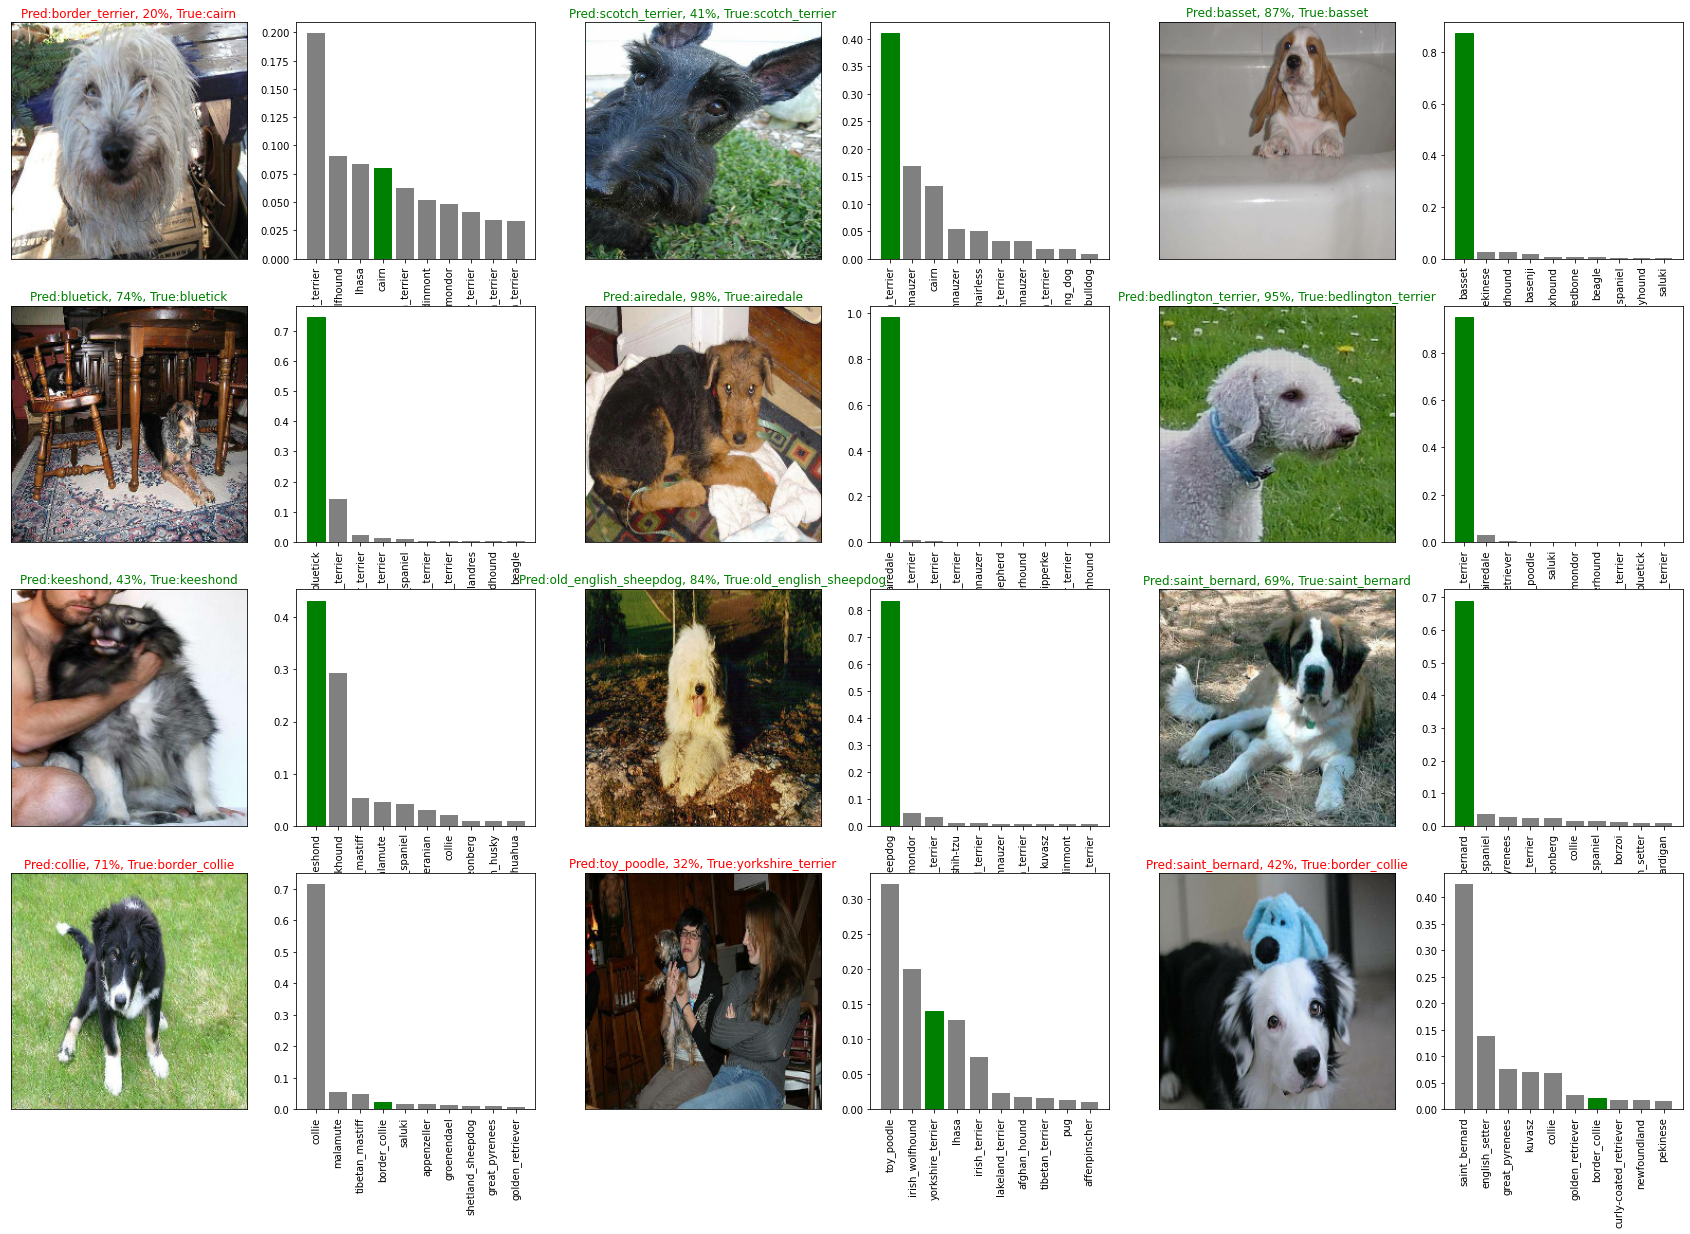

In [ ]:
i_multiplier = 0
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize = (10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_prob = predictions,
            labels = val_labels,
            images = val_images,
            n = i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_prob = predictions,
                 labels=val_labels,
                 n = i+i_multiplier)

## Saving and reloading a trained model

In [ ]:
def save_model(model, suffix = None):
  modeldir = os.path.join("/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/Models",
                          datetime.datetime.now().strftime("%Y%m&d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects = {"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
#Saving 1st model
save_model(model, suffix = "1000_images_mobilenetv2_Adam")

Saving model to: /content/drive/MyDrive/Colab Notebooks/dog-breed-identification/Models/202211&d-17201668360007-1000_images_mobilenetv2_Adam.h5...


'/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/Models/202211&d-17201668360007-1000_images_mobilenetv2_Adam.h5'

In [ ]:
loaded_model = load_model()

## Training the model on the full set

In [ ]:
full_data = create_data_batches(X, Y)

Creating training data batches...


In [ ]:
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
full_model_tensorboard = create_tensorboard_callback()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "accuracy", patience = 3)

In [ ]:
full_model.fit(x = full_data, epochs = NUM_EPOCHS, callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 1577s 5s/step - loss: 1.3433 - accuracy: 0.6706
Epoch 2/100
320/320 [==============================] - 41s 129ms/step - loss: 0.4049 - accuracy: 0.8823
Epoch 3/100
320/320 [==============================] - 41s 129ms/step - loss: 0.2395 - accuracy: 0.9330
Epoch 4/100
320/320 [==============================] - 43s 135ms/step - loss: 0.1576 - accuracy: 0.9622
Epoch 5/100
320/320 [==============================] - 45s 141ms/step - loss: 0.1047 - accuracy: 0.9800
Epoch 6/100
320/320 [==============================] - 57s 177ms/step - loss: 0.0789 - accuracy: 0.9864
Epoch 7/100
320/320 [==============================] - 47s 148ms/step - loss: 0.0575 - accuracy: 0.9921
Epoch 8/100
320/320 [==============================] - 44s 138ms/step - loss: 0.0470 - accuracy: 0.9938
Epoch 9/100
320/320 [==============================] - 46s 142ms/step - loss: 0.0367 - accuracy: 0.9964
Epoch 10/100
320/320 [==============================] - 45s 142ms

In [ ]:
save_model(full_model, suffix = "full_image_set_mobilenetv2_Adam")

Saving model to: /content/drive/MyDrive/Colab Notebooks/dog-breed-identification/Models/202211&d-12211667391704-full_image_set_mobilenetv2_Adam.h5...


'/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/Models/202211&d-12211667391704-full_image_set_mobilenetv2_Adam.h5'

In [6]:
loaded_full_model = load_model("/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/Models/202211&d-12211667391704-full_image_set_mobilenetv2_Adam.h5")

Loading saved model from: /content/drive/MyDrive/Colab Notebooks/dog-breed-identification/Models/202211&d-12211667391704-full_image_set_mobilenetv2_Adam.h5


## Making predictions on the Test Set
We will need to
* Get the test images filenames
* Convert the filenames into test data batches using `create_data_batches()` and setting the test_data parameter to true
* Make a prediction array by passing the test batches to the `predict()` method called on our model.

In [47]:
#Load the test image filenames
test_path = "/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames


['/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e6e1e02b07347a522f96eba87d29a5c0.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e774fbfeb4b712ca042f93edea3835af.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e7ce78e874945f182a4f5149aa505b09.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e7e9624f2a2e61ab187358f5968bfde8.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e76a7a1d23d687b5015b07df762c0c10.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e7f95aabf775a636b3893ffa120adaf9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e7afcce6e45858fc3b294cc5c0b15a53.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e6e8ae7dc0e71c6ae868fd3371fde010.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/test/e6ed62f411426a4f7e26e6ccdbaf7ecc.jpg',
 '/content

In [48]:
len(test_filenames)

10357

In [49]:
#Create test data batches
test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches...


In [45]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [46]:
#Make the predictions
test_predictions = loaded_full_model.predict(test_data, verbose = 1)

KeyboardInterrupt: ignored

In [ ]:
test_predictions

In [ ]:
#Save predictions
np.savetxt("/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/preds_array.csv", test_predictions, delimiter = ",")

In [ ]:
test_predictions = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/preds_array.csv", delimiter = ",")

In [ ]:
test_predictions.shape

(10357, 120)

## Submit to kaggle
In order to do that, we need to follow the specifications given here: https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation. That is, we must 

* Create a dataframe with an ID and a column for each different dog breed.
* Add data to the ID column by extracting the test image ID from the filepaths
* Add the predictions in each dog breed column
* Export the dataframe as a csv

In [ ]:
 #Create the dataframe
 preds_df = pd.DataFrame(columns = ["id"]+list(unique_breeds))
 preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [ ]:
#Append test image id
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

NameError: ignored

In [ ]:
# Add the prediction probabilities
preds_df[list(unique_breeds)] = test_predictions
len(preds_df)

10357

In [ ]:
#Export
preds_df.to_csv("/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/full_model_preds_submission_1.csv", index = False)

## Making predictions on Custom Images
We will need to:
* get the filepaths of our own images
* Turn the filepaths into data batches (with test_data = True)
* Pass the custom image data batch to our model's 'predict()' method
* Convert the prediction into a understandable manner.




In [ ]:
custom_path = "/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/Dog_pics/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

['/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/Dog_pics/IMG_20201018_172446502.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification/Dog_pics/IMG_20201018_163918413.jpg']

In [ ]:
#Turn the image sinto batches
custom_data = create_data_batches(custom_image_paths, test_data = True)

Creating test data batches...


In [ ]:
custom_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
#Make Predictions
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 0s 442ms/step


In [ ]:
custom_preds

array([[3.65522908e-07, 1.23272548e-05, 1.56732722e-06, 2.95465099e-07,
        1.18192193e-05, 1.66384524e-07, 2.46131719e-07, 2.58663011e-08,
        1.49847565e-07, 3.82357150e-08, 3.67800845e-10, 2.48488010e-04,
        1.38986262e-08, 2.26058182e-05, 5.66344650e-04, 1.23948303e-06,
        2.99860276e-05, 2.78872940e-05, 1.94798722e-05, 1.64858611e-05,
        1.95934217e-06, 1.78605347e-07, 1.22950951e-07, 5.80134110e-05,
        1.73811582e-04, 3.16339174e-05, 1.98909866e-08, 2.22156427e-06,
        7.63126227e-05, 5.27557095e-05, 6.82417303e-05, 3.56434157e-06,
        3.25453356e-02, 5.38497325e-03, 2.04448128e-07, 1.57416180e-05,
        4.88579644e-07, 1.73124022e-08, 1.09795888e-08, 6.97778635e-09,
        1.74635607e-05, 1.65324327e-05, 2.09943380e-07, 3.30510238e-06,
        5.26213671e-06, 2.51680631e-05, 5.67469724e-05, 1.25969510e-08,
        4.32693923e-06, 7.12656975e-02, 8.65268157e-05, 2.38764915e-06,
        1.40539005e-05, 3.97084223e-04, 5.83586370e-06, 4.057611

In [ ]:
custom_pred_labels = [get_label(custom_preds[i]) for i in range(len(custom_preds))]

In [ ]:
custom_pred_labels

['pekinese', 'norwich_terrier']

In [ ]:
#Get the images
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

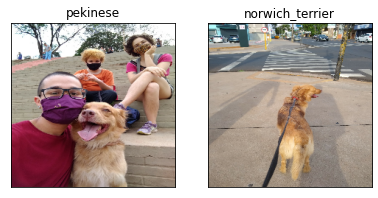

In [ ]:
#Plot it
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

## Evaluating the model

In [50]:
loaded_full_model.evaluate(test_data)

324/324 [==============================] - 4053s 13s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]